## Connect Four Game with Deep Reinforcement Learning
Xining Yuan

### Introduction

In this project, I will build an AI agent to play with the Connect Four game. Connect Four is a game where two players alternate turns dropping colored discs into a vertical grid. In this case, the board is 6 rows and 7 columns.

The game environment is built in kaggle environments. 

In [1]:
from kaggle_environments import make, evaluate
import numpy as np
import random
import matplotlib.pyplot as plt

import gym
from gym import spaces

from collections import deque
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, load_model, Sequential

Loading environment lux_ai_s2 failed: No module named 'vec_noise'


2023-06-07 17:49:45.518453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Then I create the environment, and test three heuristics agents: random, middle and left most.

In [2]:
env = make("connectx", debug=True)

In [3]:
# Two random agents play one game round
env.run(["random", "random"])

# Show the game
env.render(mode="ipython")

In [4]:
# Selects random valid column
def agent_random(obs, config):
    valid_moves = [col for col in range(config.columns) if obs.board[col] == 0]
    return random.choice(valid_moves)

# Selects middle column
def agent_middle(obs, config):
    return config.columns//2

# Selects leftmost valid column
def agent_leftmost(obs, config):
    valid_moves = [col for col in range(config.columns) if obs.board[col] == 0]
    return valid_moves[0]

In [5]:
# Agents play one game round
env.run([agent_leftmost, "random"])

# Show the game
env.render(mode="ipython")

In [6]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [7]:
get_win_percentages(agent1=agent_leftmost, agent2=agent_random)

Agent 1 Win Percentage: 0.85
Agent 2 Win Percentage: 0.15
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


### Deep Q-learning

Now I try to build a neural network agent based on deep Q-learning (DQN). This agent should performs optimal Connect Four playing strategy, which is defined as the sequence of turn actions that maximizes the probability of winning a single Connect Four game.
- Action Space: Each agent has at most seven possible actions (place dice at column 0 to 6) that they can take at any given state.
- State Space: A state is the current board that agents can see.

In this project, I explore different combinations of neural networks and Q-learning. Q-learning finds a policy that is optimal in the sense that it maximizes the expected value of the total reward over any and all successive steps, starting from the current state. "Q" is defined as "quality" of an action taken in a given state, i.e.,
$$Q: S\times A \rightarrow \mathbb{R}$$
The core of the algorithm is a value iteration update, using the weighted average of the old value and the new information:
$$Q^{new}(s_t, a_t) \leftarrow (1-\alpha) Q(s_t, a_t) + \alpha \left(r_t + \gamma \max Q(s_{t+1}, a)\right)$$ where $r_t$ is the reward received when moving from the state $s_t$ to the state $s_{t+1}$ and $\alpha$ os the learning rate $0 < \alpha \le 1$.

The reward is assigned as
-  +1, if agent wins in that move
- 10, if agent plays an invalid move
- 1, if agent loses in the next move
- 1/42, if agent drops a dice


In [8]:
# define environment
class ConnectFourGym(gym.Env):
    def __init__(self, agent2="random", switch_prob=0.5):
        self.env = make("connectx", debug=True)
        self.pair = [None, agent2]
        self.trainer = self.env.train(self.pair)
        config = self.env.configuration
        self.rows = self.env.configuration.rows
        self.columns = self.env.configuration.columns
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(1,self.rows,self.columns), dtype=int)
        # self.observation_space = spaces.Discrete(self.rows * self.columns)
        self.switch_prob = switch_prob
        
    def switch_side(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)
    
    def switch_trainer(self):
        current_trainer_random = 'random' in self.pair 
        if current_trainer_random:
            self.pair = [None, 'negamax']
        else:
            self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
    
    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        if random.uniform(0, 1) < self.switch_prob: # switch side
            self.switch_side()
        #if random.uniform(0, 1) < self.switch_prob: # switch trainer
        #    self.switch_trainer()        
        return self.trainer.reset()
    
    def render(self, **kwargs):
        return self.env.render(**kwargs)

#### FCN model
Here I use fully connected network firstly. It takes the flatten board as input and all the hidden layers are dense fully connected layers. The output will be the probability of each action. Therefore, I can choose the column with highest probability to drop the dice

In [9]:
# policy network
def ConnectFourFCN(input_shape, action_space):
    X_input = Input(input_shape)
    # input_shape = (num_states, )?
    # Input Layer of state size(42) and Hidden Layer with 512 nodes
    X = Dense(512, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X_input)
    # X = Dense(512, activation="relu", kernel_initializer='he_uniform')(X_input)

    # Hidden layer with 256 nodes
    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)
    
    # Hidden layer with 64 nodes
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)

    # Output Layer with # of actions: 2 nodes (left, right)
    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X, name='c4_DQN_FCN')
    model.compile(loss="mse", optimizer=RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01), 
                  metrics=["accuracy"])
    model.summary()
    return model

In this experiment, I do not check whether the action is invalid. Thefore, the model can experience -10 reward and learn to avoid the invalid step itself. 

In [10]:
# Define DQN agent
class DQNAgent:
    def __init__(self, env, state_size, action_size):
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.EPISODES = 1000
        self.memory = deque(maxlen=1000)
        
        self.gamma = 0.95 # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.999
        self.batch_size = 64
        self.train_start = 1

        # create main model
        self.model = ConnectFourFCN(input_shape = (self.state_size,), action_space = self.action_size)
        # self.model = ConnectFourFCN(input_shape = self.state_size, action_space = self.action_size)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        # implement the epsilon-greedy policy
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon * (1 - self.epsilon_decay)
        explore_prob = self.epsilon
        if np.random.rand() <= self.epsilon: # Exploration
            return random.choice([c for c in range(self.action_size) if state['board'][c] == 0])
        else:
            _state = np.array(state['board'])
            act_values = self.model.predict(np.expand_dims(_state, axis=0), verbose=0) # Exploitation
            action = np.argmax(act_values[0]) 
            return action

    # implement the Q-learning
    def replay(self):
        if len(self.memory) < self.train_start:
            return;
        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))
        
        _state = np.zeros((self.batch_size, self.env.rows))
        _next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []
        for i in range(self.batch_size):
            _state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            _next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])
            
        # compute value function
        target = self.model.predict(_state, verbose=0)
        target_next = self.model.predict(_next_state, verbose=0)

        for i in range(self.batch_size):
            # correction on the Q value for the action used,
            # if done[i] is true, then the target should be just the final reward
            if done[i]:
                target[i][action[i]] = reward[i]
                
            else:
                # else, use Bellman Equation
                # Standard - DQN
                # DQN chooses the max Q value among next actions
                # selection and evaluation of action is on the target Q Network
                # target = max_a' (r + gamma*Q_target_next(s', a'))
                target[i][action[i]] = np.amax(reward[i] + self.gamma * target[i])
                
        self.model.fit(_state, target, batch_size=self.batch_size, verbose=0)
              
#         for _state, action, reward, _next_state, done in minibatch:
#             target = reward
#             if not done:
#                 target = reward + self.gamma * np.amax(self.model.predict(_next_state)[0])
#             target_f = self.model.predict(_state)
#             target_f[0][action] = target
#             self.model.fit(_state, target_f, epochs=1, verbose=0)
#         if self.epsilon > self.epsilon_min:
#             self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)
          
    def training(self, verbose=0):
        # Monitoring devices
        all_total_rewards = np.empty(self.EPISODES)
        all_avg_rewards = np.empty(self.EPISODES)
        for e in range(self.EPISODES):
            state = self.env.reset()
            done = False
            i = 0
            total_rewards = 0
            while not done:
                # self.env.render()
                action = int(self.act(state))
                next_state, reward, done, _ = self.env.step(action)
                # reward
                if not done:
                    reward = 0.0/42
                if done:
                    if reward == 1: # Won
                        reward = 1
                    elif reward == 0: # Lost
                        reward = -1
                    else: # Draw
                        reward = 0
                if state['board'][action]!=0: # invalid move: hard penalization
                    reward = -10
                self.remember(np.array(state['board']), action, reward, np.array(next_state['board']), done)
                state = next_state
                total_rewards += reward
                i += 1
            if done:
                print("episode: %d/%d, epsilon: %.2f, total: %.2f\n"%(e, self.EPISODES, 
                                                                       self.epsilon, total_rewards))
                if e % 100 == 0 :
                    self.save("./connect4_dqn.h5")
               
            if len(agent.memory) > self.batch_size:
                self.replay()

                all_total_rewards[e] = total_rewards
                avg_reward = all_total_rewards[max(0, e - 100):e].mean()
                all_avg_rewards[e] = avg_reward 
        
        if verbose == 1:
            plt.plot(all_avg_rewards)
            plt.xlabel('Episode')
            plt.ylabel('Avg rewards (100)')
            plt.show()

In [11]:
# Create ConnectFour environment 
c4env = ConnectFourGym(switch_prob = 0.5)
# state_size = (env.observation_space.shape[1], env.observation_space.shape[2])
state_size = c4env.observation_space.shape[1] * c4env.observation_space.shape[2]
action_size = c4env.observation_space.shape[1]

agent = DQNAgent(c4env, state_size, action_size)

Model: "c4_DQN_FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 dense (Dense)               (None, 512)               22016     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 170,182
Trainable params: 170,182
Non-trainable params: 0
_________________________________________________________________


In [ ]:
agent.training(verbose=1)

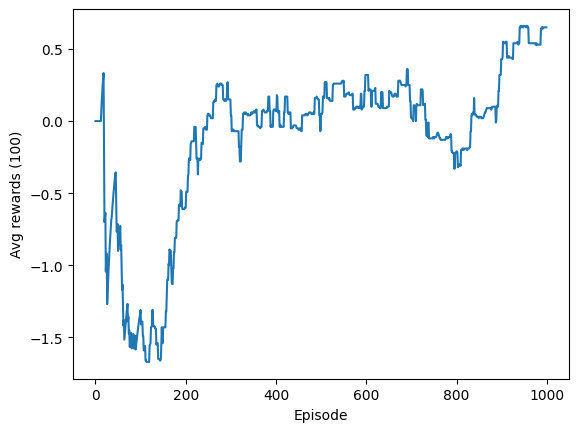

In [18]:
# def dqn_agent(obs, config):
#     act_values = agent.model.predict(np.array(obs['board']).reshape(1, 42))[0]
#     for i in range(config.columns):
#         if obs['board'][i] != 0:
#             act_values[i] = -1e7
#     return int(np.argmax(act_values))

def dqn_agent(obs, config):
    col = agent.act(obs)
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [19]:
# Two random agents play one game round
env.run([dqn_agent, "random"])

# Show the game
env.render(mode="ipython")

In [20]:
get_win_percentages(agent1=dqn_agent, agent2="random")

Agent 1 Win Percentage: 0.82
Agent 2 Win Percentage: 0.18
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


#### CNN Model
Now I tried to use convolution neural network. The reason why I tried CNN is that I can treat the state (board) as a $6\times 7$ image. And with convolution filter, the model can learn more on the local structure information. I tried different hyperparameters, and the following is a good example.

In [12]:
# policy network
def ConnectFourCNN(input_shape, action_space):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(action_space))
    model.compile(loss="mse", optimizer=RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01), 
                  metrics=["accuracy"])
    model.summary()
    return model

In [13]:
# Define DQN agent
class DQNAgent:
    def __init__(self, env, state_size, action_size):
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.EPISODES = 1000
        self.memory = deque(maxlen=1000)
        
        self.gamma = 0.95 # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.999
        self.batch_size = 64
        self.train_start = 1

        # create main model
        self.model = ConnectFourCNN(input_shape = (self.env.rows, self.env.columns, ), 
                                    action_space = self.action_size)

#     def preprocess(self, state):
#         board = np.reshape(np.array(state['board']))
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        # implement the epsilon-greedy policy
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon * (1 - self.epsilon_decay)
        explore_prob = self.epsilon
        if np.random.rand() <= self.epsilon: # Exploration
            return random.choice([c for c in range(self.action_size) if state['board'][c] == 0])
        else:
            _state = np.reshape(np.array(state['board']), (6,7,1))
            act_values = self.model.predict(np.expand_dims(_state, axis=0), verbose=0)[0] # Exploitation
            # only keep valid move
            for i in range(self.action_size):
                if state['board'][i] != 0:
                    act_values[i] = -1e7
            return int(np.argmax(act_values))

    # implement the Q-learning
    def replay(self):
        if len(self.memory) < self.train_start:
            return;
        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))
        
        _state = np.zeros((self.batch_size, self.env.rows, self.env.columns, 1))
        _next_state = np.zeros((self.batch_size, self.env.rows, self.env.columns, 1))
        action, reward, done = [], [], []
        for i in range(self.batch_size):
            _state[i] = np.reshape(minibatch[i][0], (6,7,1))
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            _next_state[i] = np.reshape(minibatch[i][3], (6,7,1))
            done.append(minibatch[i][4])
            
        # compute value function
        target = self.model.predict(_state, verbose=0)
        target_next = self.model.predict(_next_state, verbose=0)

        for i in range(self.batch_size):
            # correction on the Q value for the action used,
            # if done[i] is true, then the target should be just the final reward
            if done[i]:
                target[i][action[i]] = reward[i]
                
            else:
                # else, use Bellman Equation
                # Standard - DQN
                # DQN chooses the max Q value among next actions
                # selection and evaluation of action is on the target Q Network
                # target = max_a' (r + gamma*Q_target_next(s', a'))
                target[i][action[i]] = np.amax(reward[i] + self.gamma * target[i])
                
        self.model.fit(_state, target, batch_size=self.batch_size, verbose=0)
              
    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)
          
    def training(self, verbose=0):
        # Monitoring devices
        all_total_rewards = np.empty(self.EPISODES)
        all_avg_rewards = np.empty(self.EPISODES)
        for e in range(self.EPISODES):
            state = self.env.reset()
            done = False
            i = 0
            total_rewards = 0
            while not done:
                # self.env.render()
                action = int(self.act(state))
                next_state, reward, done, _ = self.env.step(action)
                # reward
                if not done:
                    reward = 0.0/42
                if done:
                    if reward == 1: # Won
                        reward = 1
                    elif reward == 0: # Lost
                        reward = -1
                    else: # Draw
                        reward = 0
                if state['board'][action]!=0: # invalid move: hard penalization
                    reward = -10
                self.remember(np.array(state['board']), action, reward, np.array(next_state['board']), done)
                state = next_state
                total_rewards += reward
                i += 1
            if done:
                print("episode: %d/%d, epsilon: %.2f, total: %.2f\n"%(e, self.EPISODES, 
                                                                       self.epsilon, total_rewards))
                if e % 100 == 0 :
                    self.save("./connect4_dqn.h5")
               
            if len(agent.memory) > self.batch_size:
                self.replay()

                all_total_rewards[e] = total_rewards
                avg_reward = all_total_rewards[max(0, e - 100):e].mean()
                all_avg_rewards[e] = avg_reward 
        
        if verbose == 1:
            plt.plot(all_avg_rewards)
            plt.xlabel('Episode')
            plt.ylabel('Avg rewards (100)')
            plt.show()

In [14]:
# Create ConnectFour environment 
c4env = ConnectFourGym(switch_prob = 0.5)
# state_size = (env.observation_space.shape[1], env.observation_space.shape[2])
state_size = c4env.observation_space.shape[1] * c4env.observation_space.shape[2]
action_size = c4env.action_space.n

agent = DQNAgent(c4env, state_size, action_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 7, 32)          320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 7, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 2688)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                172096    
                                                                 
 dense_5 (Dense)             (None, 7)                 455       
                                                                 
Total params: 228,295
Trainable params: 228,295
Non-trai

In [ ]:
agent.training(verbose=1)

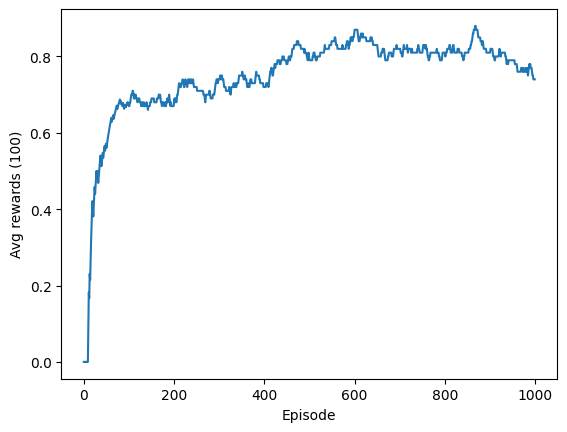

In [64]:
def dqn_agent(obs, config):
    col = agent.act(obs)
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [65]:
# Two random agents play one game round
env.run([dqn_agent, "random"])

# Show the game
env.render(mode="ipython")

In [66]:
get_win_percentages(agent1=dqn_agent, agent2="random")

Agent 1 Win Percentage: 0.77
Agent 2 Win Percentage: 0.23
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


### Conclusion, and Future Work
In this project, I built different intelligence agencies using Reinforcement Learning and Neural Network.
The CNN performs slightly worse than FCN, in our experiment.
All the models perform better than random choice or other simple heuristic method.

In the future, I can try other reinforcement learning algorithm such as policy gradient method, and compare the performance of different algorithms on this Connect Four game.
